In [3]:
from collections import defaultdict, Counter, namedtuple
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats
import random
import copy

In [1553]:
chrom = 'X'
chroms = ['X']
ihart_family_sizes = [3, 4, 5, 6, 7]
ihart_phase_dir = '../phased_ihart_males_only'
ssc_family_sizes = [3, 4]
ssc_phase_dir = '../phased_ssc'

PAR1X_end = 2699520
PAR2X_start = 154931044

In [1554]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [1555]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}

chrom_offsets = [0]
for chrom in chroms:
    chrom_offsets.append(chrom_offsets[-1]+chrom_lengths[chrom])
print(chrom_offsets)

[0, 155270560]


# Filter Families


In [1556]:
family_to_individuals = dict()

def load_families(phase_dir, family_sizes):
    family_to_chroms = defaultdict(set)
    
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_to_include = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_to_include))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    return families_to_include
ihart_families = load_families(ihart_phase_dir, ihart_family_sizes)
ssc_families = load_families(ssc_phase_dir, ssc_family_sizes)

X Families with all chroms 832
Counter({1: 832})
X Families with all chroms 519
Counter({1: 519})


In [1593]:
# filter SSC to have only males
ssc_families = [famkey for famkey in ssc_families if len(family_to_individuals[famkey])==4 and child_id_to_sex[family_to_individuals[famkey][2]] == '1' and child_id_to_sex[family_to_individuals[famkey][3]] == '1']
print(len(ssc_families))



206


In [1594]:
ihart_individuals = sorted(sum([family_to_individuals[k] for k in ihart_families], []))
ihart_ind_to_index = dict([(x, i) for i, x in enumerate(ihart_individuals)])
ssc_individuals = sorted(sum([family_to_individuals[k] for k in ssc_families], []))
ssc_ind_to_index = dict([(x, i) for i, x in enumerate(ssc_individuals)])

# Read in deletions


In [1595]:
Deletion = namedtuple('Deletion', ['family', 'chrom', 'start_pos', 'end_pos', 'length', 'opt_start_pos', 'opt_end_pos', 'trans', 'notrans', 
                                      'family_size', 'is_mat', 'is_pat', 'state', 'dataset'])



In [1596]:
from collections import defaultdict

def read_deletions(chrom, phase_dir, family_sizes, families, dataset):
    deletions = []

    for j in family_sizes:
            
        # load deletions
        family_to_states = defaultdict(list)
        family_to_pos = defaultdict(list)
        with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in families:
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                    assert end_pos >= start_pos
                        
                    # if a segment is never inherited, we don't know if it has a deletion or not
                    if state[0] == 0 and state[1] == 0:
                        pass
                    else:
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                            state[0] = -1
                        if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                            state[1] = -1
                    if state[2] == 0 and state[3] == 0:
                        pass
                    else:
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                            state[2] = -1
                        if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                            state[3] = -1

                    family_to_states[family_key].append(state)
                    family_to_pos[family_key].append((start_pos, end_pos))

        # for each family, detect deletion transmission
        for family_key, states in family_to_states.items():
            states = np.asarray(states)
            assert np.all(states[0, :4] != 0)
            assert np.all(states[-1, :4] != 0)
            positions = np.asarray(family_to_pos[family_key])
            inds = family_to_individuals[family_key]
            
            if child_id_to_sex[inds[2]] == '2':
                # if the first child is a girl, then p1 is dad's X and p2 is his Y
                dad_x = 2
            else:
                # otherwise, p2 is dad's X and p1 is his Y
                dad_x = 3

            # for each ancestral chromosome
            for anc in range(4):
                is_mat = anc==0 or anc==1
                is_pat = anc==2 or anc==3
                    
                start_indices = np.where((states[:-1, anc] != 0) & (states[1:, anc] == 0))[0]+1
                end_indices = np.where((states[:-1, anc] == 0) & (states[1:, anc] != 0))[0]+1
                for s_ind, e_ind in zip(start_indices, end_indices):
                    
                    # check if parental double deletion
                    if is_mat:
                        is_double = np.all(states[s_ind, :2]==0)
                    else:
                        is_double = np.all(states[s_ind, 2:4]==0)
        
                    # check if recombination event occured and that inheritance state is known
                    has_recomb = False
                    if is_mat:
                        indices = np.arange(4, states.shape[1]-1, 2)
                    else:
                        indices = np.arange(5, states.shape[1]-1, 2)
                        
                    inh_known = np.all(states[s_ind:e_ind, indices] != -1)
                        
                    for i in range(s_ind, e_ind):
                        if np.any(states[i, indices] != states[s_ind, indices]):
                            has_recomb = True
                            
                    # check if in ok region
                    ok_region = np.all(states[s_ind:e_ind, -1] == 0)
                    
                    # check if we're in the PAR
                    in_par = (positions[s_ind, 0] <= PAR1X_end) or (PAR2X_start <= positions[e_ind-1, 1])
                    
                    if ok_region and inh_known and (not has_recomb) and (is_mat or anc==dad_x): #and (not in_par) :
                        start_pos, end_pos = positions[s_ind, 0], positions[e_ind-1, 1]
                        
                        # find boundaries of the deletion
                        #print(s_ind, e_ind)
                        opt_start_index = s_ind
                        while states[opt_start_index, anc] != 1 and opt_start_index > 0:
                            opt_start_index -= 1
                        opt_start_pos = positions[opt_start_index+1, 0]
                        
                        opt_end_index = e_ind
                        while(states[opt_end_index, anc]) != 1 and opt_end_index < states.shape[0]-1:
                            opt_end_index += 1
                        opt_end_pos = positions[e_ind-1, 1]
                        
                        assert start_pos <= end_pos
                        assert opt_start_pos <= start_pos
                        assert end_pos <= opt_end_pos
                        
                        state = states[s_ind, :]
                    
                        # children
                        trans, notrans = [], []
                        for k, child in zip(range(2, j), inds[2:]):
                            mom_s, dad_s = state[(2*k):(2*(k+1))]

                            if is_mat:
                                assert mom_s != -1
                                if anc==mom_s:
                                    trans.append(child)
                                else:
                                    notrans.append(child)
                            if is_pat:
                                assert dad_s != -1
                                if anc==2+dad_s:
                                    trans.append(child)
                                else:
                                    notrans.append(child)

                        if (len(trans) + len(notrans) == j-2) and (len(trans) > 0):
                            deletions.append(Deletion(family_key, chrom, start_pos, end_pos, end_pos-start_pos+1, 
                                                              opt_start_pos, opt_end_pos,
                                                              tuple(trans), tuple(notrans), j, is_mat, is_pat,
                                                              tuple(states[s_ind, :]), dataset))
                        
    # sort deletions
    deletions = sorted(deletions, key=lambda x: x.start_pos)
    return deletions



In [1597]:
class DeletionCollection:
    def __init__(self, deletion, matches):
        self.deletion = deletion
        self.matches = matches

def create_collections(deletions):
    collections = []
    
    starts = np.array([d.start_pos for d in deletions])
    stops = np.array([d.end_pos for d in deletions])

    ordered_start_indices = np.argsort(starts)
    ordered_starts = starts[ordered_start_indices]
    ordered_stop_indices = np.argsort(stops)
    ordered_stops = stops[ordered_stop_indices]
        
    insert_starts_in_stops = np.searchsorted(ordered_stops, starts)
    insert_stops_in_starts = np.searchsorted(ordered_starts, stops, side='right')
        
    indices = np.ones((len(deletions),), dtype=bool)

    for del_index, main_d in enumerate(deletions):
        indices[:] = True
        indices[ordered_stop_indices[:insert_starts_in_stops[del_index]]] = False
        indices[ordered_start_indices[insert_stops_in_starts[del_index]:]] = False

        collections.append(DeletionCollection(main_d, [deletions[j] for j in np.where(indices)[0]]))
    return collections



In [1598]:
def prune_deletions(collections, share_cutoff=0.8):    
    # first, prune deletions that don't overlap with the main deletion by share_cutoff
    for c in collections:
        lengths = np.array([d.length for d in c.matches])
        overlaps1 = np.array([min(d.opt_end_pos, c.deletion.end_pos)-max(d.opt_start_pos, c.deletion.start_pos)+1 for d in c.matches])
        overlaps2 = np.array([min(d.end_pos, c.deletion.opt_end_pos)-max(d.start_pos, c.deletion.opt_start_pos)+1 for d in c.matches])
        c.matches = set([c.matches[j] for j in np.where((overlaps2 >= share_cutoff*lengths) & (overlaps1 >= share_cutoff*c.deletion.length))[0]])
    return collections

def prune_collections(collections):
        
    deletion_to_index = dict([(x.deletion, i) for i, x in enumerate(collections)])
    
    # now, get rid of collections that are identical to other collections
    for c in collections:
        if c is not None:
            for d in c.matches:
                index = deletion_to_index[d]
                if (c.deletion != d) and (collections[index] is not None) and (c.matches == collections[index].matches):
                    collections[index] = None
    #print('removing %d of %d' % (len([x for x in collections if x is None]), len(collections)))
    collections = [x for x in collections if x is not None]
    return collections





In [1599]:
print(chrom, end=' ')
    
ihart_deletions = read_deletions(chrom, ihart_phase_dir, ihart_family_sizes, ihart_families, 'iHART')
print('id', end=' ')
    
ssc_deletions = read_deletions(chrom, ssc_phase_dir, ssc_family_sizes, ssc_families, 'SSC')
print('sd', end=' ')
    
deletions = sorted(ihart_deletions + ssc_deletions, key=lambda x: x.start_pos)
#deletions = ihart_deletions
collections = create_collections(deletions)
print('c', end=' ')
    
collections = prune_deletions(collections)
print('p', end=' ')
    
collections = prune_collections(collections)
print(len(collections))
    
all_collections = collections  
    

X id sd c p 5811


In [1600]:
deletion_to_index = dict([(x.deletion, i) for i, x in enumerate(all_collections)])

ind_indices = np.ones((len(all_collections),), dtype=bool)
used_deletions = set()
for j in np.flip(np.argsort([sum([len(d.trans)+len(d.notrans) for d in c.matches]) for c in all_collections])):
    c = all_collections[j]
    ind_indices[j] = np.all([x not in used_deletions for x in c.matches])
    if ind_indices[j]:
        used_deletions.update(c.matches)
        
            
print(np.sum(ind_indices))

4213


# Test paternal vs maternal transmission in females

In [1601]:
def create_contingency(collections, family_sizes, filter_child, verbose=True):
    # chrom, collection, family_size, notrans/trans
    contingency = np.zeros((len(collections), len(family_sizes), 2))
    familysize_to_index = dict([(x, i) for i, x in enumerate(family_sizes)])
    if verbose:
        print(chrom, end=' ')
    for j, c in enumerate(collections):
        for k, s in enumerate(family_sizes):
            contingency[j, k, 0] = sum([len([x for x in d.trans if filter_child(x, d.is_mat, d.dataset) and d.is_mat]) for d in c.matches if d.family_size==s])
            contingency[j, k, 1] = sum([len([x for x in d.trans if filter_child(x, d.is_mat, d.dataset) and not d.is_mat]) for d in c.matches if d.family_size==s])
    return contingency

contingency_ihart_aff = np.sum(create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and child_id_to_sex[child_id]=='2'), axis=1)
contingency_ihart_unaff = np.sum(create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and child_id_to_sex[child_id]=='2'), axis=1)
contingency_ihart_all = np.sum(create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_sex[child_id]=='2' ), axis=1)


X X X 

In [1602]:
def calc_pvalue(mat, pat):
    return (scipy.stats.binom_test(mat, mat+pat, 0.5, alternative='greater'),
                           scipy.stats.binom_test(mat, mat+pat, 0.5, alternative='less'))
        

In [1603]:
def calculate_pvalues(contingency):
    # chrom, collection, greater/less
    pvalues = np.ones((contingency.shape[0], 2))
    print(chrom, end=' ')
    for j in range(contingency.shape[0]):
        if np.sum(contingency[j, :]) > 0:
            pvalues[j, :] = calc_pvalue(contingency[j, 0], contingency[j, 1])
        else:
            pvalues[j, :] = np.nan
    return pvalues

pvalues_ihart_aff = calculate_pvalues(contingency_ihart_aff)
pvalues_ihart_unaff = calculate_pvalues(contingency_ihart_unaff)
pvalues_ihart_all = calculate_pvalues(contingency_ihart_all)

X X X 

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


-inf 5.065280871102755


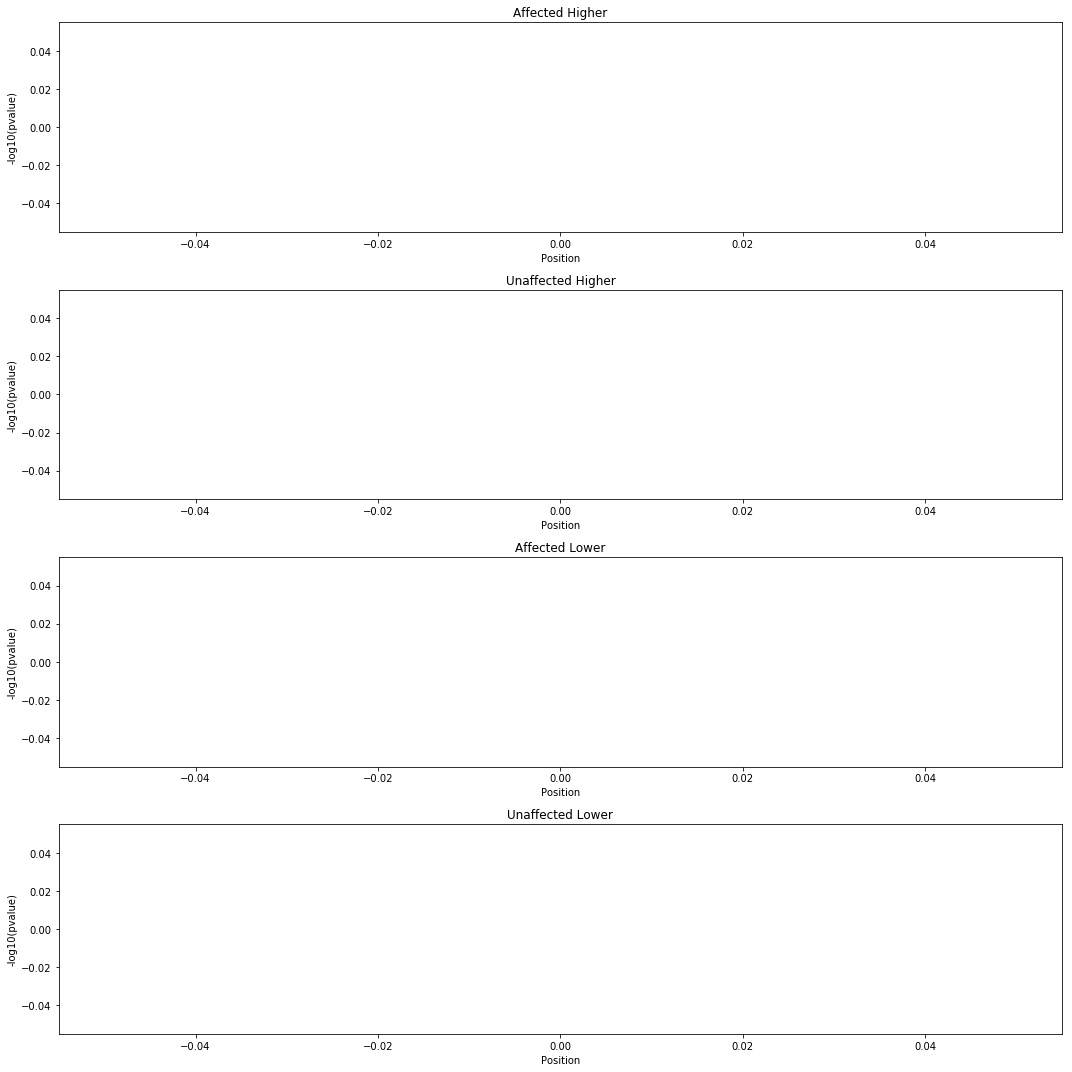

In [1604]:
plt.figure(figsize=(15, 15))
  
cutoff = -np.log10(0.05/np.sum(np.sum(contingency_ihart_all, axis=1)>5))
print(cutoff, -np.log10(0.05/len(all_collections)))
plt.subplot(4, 1, 1)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Affected Higher')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions, -np.log10(pvalues_ihart_aff[:, 0]), alpha=0.5)
    
plt.subplot(4, 1, 2)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Unaffected Higher')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions, -np.log10(pvalues_ihart_unaff[:, 0]), alpha=0.5)

plt.subplot(4, 1, 3)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Affected Lower')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions, -np.log10(pvalues_ihart_aff[:, 1]), alpha=0.5)

plt.subplot(4, 1, 4)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Unaffected Lower')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions, -np.log10(pvalues_ihart_unaff[:, 1]), alpha=0.5)

plt.tight_layout()
plt.show()

In [1605]:
def calculate_transmission_rates(contingency, verbose=True, z=1.96):
    # chrom, collection, family_size
    trans_rates = np.ones((contingency.shape[0],))
    trans_rates_conf = np.ones((contingency.shape[0], 2))
    if verbose:
        print(chrom, end=' ')
    for j in range(contingency.shape[0]):
        mat, pat = contingency[j, 0], contingency[j, 1]
        if mat+pat == 0:
            p, u, l = np.nan, np.nan, np.nan
        else:
            p = ((z*z/2)+mat)/(mat+pat+(z*z))
            c = z*np.sqrt(p*(1-p)/(mat+pat+(z*z)))
            l, u = p-c, p+c
        trans_rates[j] = p
        trans_rates_conf[j, :] = (l, u)
    return trans_rates, trans_rates_conf

transrates_ihart_aff, transratesconf_ihart_aff = calculate_transmission_rates(contingency_ihart_aff)
transrates_ihart_unaff, transratesconf_ihart_unaff = calculate_transmission_rates(contingency_ihart_unaff)
transrates_ihart_all, transratesconf_ihart_all = calculate_transmission_rates(contingency_ihart_all)


X X X 

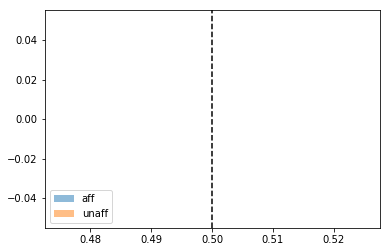

In [1606]:
plt.hist(transrates_ihart_aff, bins=np.arange(0, 1.05, 0.05), alpha=0.5, label='aff', density=True)
plt.hist(transrates_ihart_unaff, bins=np.arange(0, 1.05, 0.05), alpha=0.5, label='unaff', density=True)

plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.show()

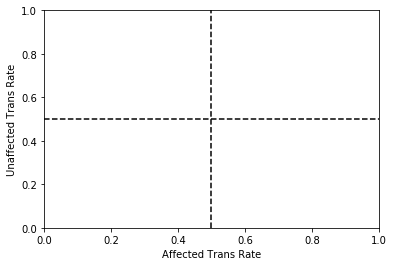

In [1607]:
plt.scatter(np.hstack(transrates_ihart_aff), np.hstack(transrates_ihart_unaff), alpha=0.1)

plt.xlabel('Affected Trans Rate')
plt.ylabel('Unaffected Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

In [1608]:
print(cutoff)

def printout(j):
    print('%s:%d-%d %0.2f/%0.2f/%0.2f/%0.2f (%0.2f [%0.2f, %0.2f, %d]/%0.2f [%0.2f, %0.2f, %d])' % (
            chrom, all_collections[j].deletion.start_pos, all_collections[j].deletion.end_pos, 
            -np.log10(pvalues_ihart_aff[j, 0]), -np.log10(pvalues_ihart_aff[j, 1]), -np.log10(pvalues_ihart_unaff[j, 0]), -np.log10(pvalues_ihart_unaff[j, 1]),
            transrates_ihart_aff[j], transratesconf_ihart_aff[j, 0], transratesconf_ihart_aff[j, 1], np.sum(contingency_ihart_aff[j, :]), 
            transrates_ihart_unaff[j], transratesconf_ihart_unaff[j, 0], transratesconf_ihart_unaff[j, 1], np.sum(contingency_ihart_unaff[j, :])))

print('Affected Higher')
for j in np.where((-np.log10(pvalues_ihart_aff[:, 0]) >= cutoff))[0]:
    printout(j)

print('Unaffected Higher')
for j in np.where((-np.log10(pvalues_ihart_unaff[:, 0]) >= cutoff))[0]:
    printout(j)

print('Affected Lower')
for j in np.where((-np.log10(pvalues_ihart_aff[:, 1]) >= cutoff))[0]:
    printout(j)
        
print('Unaffected Lower')
for j in np.where((-np.log10(pvalues_ihart_unaff[:, 1]) >= cutoff))[0]:
    printout(j)
        
        

-inf
Affected Higher
Unaffected Higher
Affected Lower
Unaffected Lower


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater_equal
  # This is added back by InteractiveShellApp.init_path()
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater_equal
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater_equal


In [1609]:
print('Affected Higher')
for j in np.where(transratesconf_ihart_unaff[:, 1] < transratesconf_ihart_aff[:, 0])[0]:
    printout(j)

print('Affected Lower')
for j in np.where(transratesconf_ihart_aff[:, 1] < transratesconf_ihart_unaff[:, 0])[0]:
    printout(j)
    printout(j+1)
    printout(j+2)


Affected Higher
Affected Lower


In [1610]:
def calc_hypergeometric_pvalue(aff_mat, unaff_mat, aff_pat, unaff_pat):
    cdf = scipy.stats.hypergeom.cdf(aff_mat, 
                                     aff_mat+unaff_mat+aff_pat+unaff_pat, 
                                     aff_mat+aff_pat, 
                                     aff_mat+unaff_mat)
    pmf = scipy.stats.hypergeom.pmf(aff_mat, 
                                     aff_mat+unaff_mat+aff_pat+unaff_pat, 
                                     aff_mat+aff_pat, 
                                     aff_mat+unaff_mat)
    sf = scipy.stats.hypergeom.sf(aff_mat, 
                                     aff_mat+unaff_mat+aff_pat+unaff_pat, 
                                     aff_mat+aff_pat, 
                                     aff_mat+unaff_mat)
    return min(cdf, sf+pmf)


In [1611]:
hypergeom_p = np.ones((contingency_ihart_aff.shape[0], ))
for j in range(contingency_ihart_aff.shape[0]):
    hypergeom_p[j] = calc_hypergeometric_pvalue(contingency_ihart_aff[j, 0], contingency_ihart_unaff[j, 0], 
                                             contingency_ihart_aff[j, 1], contingency_ihart_unaff[j, 1])
    
print(np.min(hypergeom_p), np.max(hypergeom_p))

1.0 1.0


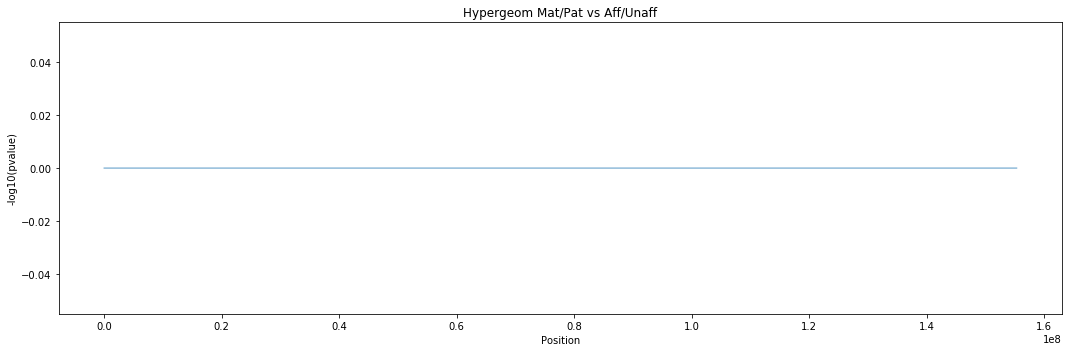

In [1612]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 1, 1)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Hypergeom Mat/Pat vs Aff/Unaff')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions, -np.log10(hypergeom_p[:]), alpha=0.5)

plt.tight_layout()
plt.show()

# Test maternal transmission rates

In [1613]:
def create_contingency(collections, family_sizes, filter_child, verbose=True):
    # chrom, collection, family_size, notrans/trans
    contingency = np.zeros((len(collections), len(family_sizes), 2))
    familysize_to_index = dict([(x, i) for i, x in enumerate(family_sizes)])
    if verbose:
        print(chrom, end=' ')
    for j, c in enumerate(collections):
        for k, s in enumerate(family_sizes):
            contingency[j, k, 0] = sum([len([x for x in d.notrans if filter_child(x, d.is_mat, d.dataset)]) for d in c.matches if d.family_size==s])
            contingency[j, k, 1] = sum([len([x for x in d.trans if filter_child(x, d.is_mat, d.dataset)]) for d in c.matches if d.family_size==s])
    return contingency

#ihart
contingency_ihart_aff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and dataset=='iHART')
contingency_ihart_unaff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and dataset=='iHART')

contingency_ihart_aff_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and child_id_to_sex[child_id]=='1' and dataset=='iHART')
contingency_ihart_unaff_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and child_id_to_sex[child_id]=='1' and dataset=='iHART')

contingency_ihart_aff_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and child_id_to_sex[child_id]=='2' and dataset=='iHART')
contingency_ihart_unaff_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and child_id_to_sex[child_id]=='2' and dataset=='iHART')

contingency_ihart_aff_f_pat = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and (not is_mat) and child_id_to_sex[child_id]=='2' and dataset=='iHART')
contingency_ihart_unaff_f_pat = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and (not is_mat) and child_id_to_sex[child_id]=='2' and dataset=='iHART')

#ssc
contingency_ssc_aff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and dataset=='SSC')
contingency_ssc_unaff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and dataset=='SSC')

contingency_ssc_aff_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and child_id_to_sex[child_id]=='1' and dataset=='SSC')
contingency_ssc_unaff_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and child_id_to_sex[child_id]=='1' and dataset=='SSC')

contingency_ssc_aff_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and child_id_to_sex[child_id]=='2' and dataset=='SSC')
contingency_ssc_unaff_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and child_id_to_sex[child_id]=='2' and dataset=='SSC')

contingency_ssc_aff_f_pat = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and (not is_mat) and child_id_to_sex[child_id]=='2' and dataset=='SSC')
contingency_ssc_unaff_f_pat = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and (not is_mat) and child_id_to_sex[child_id]=='2' and dataset=='SSC')

#both
contingency_both_aff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat)
contingency_both_unaff = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat)

contingency_both_aff_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and child_id_to_sex[child_id]=='1')
contingency_both_unaff_m = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and child_id_to_sex[child_id]=='1')

contingency_both_aff_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and is_mat and child_id_to_sex[child_id]=='2')
contingency_both_unaff_f = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and is_mat and child_id_to_sex[child_id]=='2')

contingency_both_aff_f_pat = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='2' and (not is_mat) and child_id_to_sex[child_id]=='2')
contingency_both_unaff_f_pat = create_contingency(all_collections, ihart_family_sizes, lambda child_id, is_mat, dataset: child_id_to_affected[child_id]=='1' and (not is_mat) and child_id_to_sex[child_id]=='2')




X X X X X X X X X X X X X X X X X X X X X X X X 

In [1614]:
cached_pvalue = dict()
ps = [None, None, None] + [pow(2, c-1)/(pow(2, c)-1) for c in range(1, 6)]
print(ps)

def calc_pvalue(trans, notrans, m):
    k = (trans, notrans, m)
    if k not in cached_pvalue:
        cached_pvalue[k] = (scipy.stats.binom_test(trans, trans+notrans, ps[m], alternative='greater'),
                           scipy.stats.binom_test(trans, trans+notrans, ps[m], alternative='less'))
        
    return cached_pvalue[k]

[None, None, None, 1.0, 0.6666666666666666, 0.5714285714285714, 0.5333333333333333, 0.5161290322580645]


In [1615]:
def combine_pvalues(pvalues):
    comb_p = [np.nan, np.nan]
    indices = ~np.isnan(pvalues[:, 0])
    if np.sum(indices) > 0:
        comb_p[0] = scipy.stats.combine_pvalues(pvalues[indices, 0], method='fisher')[1]
    indices = ~np.isnan(pvalues[:, 1])
    if np.sum(indices) > 0:
        comb_p[1] = scipy.stats.combine_pvalues(pvalues[indices, 1], method='fisher')[1]
    return comb_p


In [1616]:
def calculate_pvalues(contingency, family_sizes):
    # chrom, collection, family_size, greater/less
    pvalues = np.ones((contingency.shape[0], contingency.shape[1]+1, 2))
    print(chrom, end=' ')
    for j in range(contingency.shape[0]):
        if np.sum(contingency[j, :, :]) > 5:
            for k in range(contingency.shape[1]):
                if np.sum(contingency[j, k, :]) != 0:
                    pvalues[j, k, :] = calc_pvalue(contingency[j, k, 1], contingency[j, k, 0], family_sizes[k])
                else:
                    pvalues[j, k, :] = np.nan
            pvalues[j, -1, :] = combine_pvalues(pvalues[j, :, :])
        else:
            pvalues[j, :, :] = 1
    return pvalues

#ihart
pvalues_ihart_aff = calculate_pvalues(contingency_ihart_aff, ihart_family_sizes)
pvalues_ihart_unaff = calculate_pvalues(contingency_ihart_unaff, ihart_family_sizes)

pvalues_ihart_aff_m = calculate_pvalues(contingency_ihart_aff_m, ihart_family_sizes)
pvalues_ihart_unaff_m = calculate_pvalues(contingency_ihart_unaff_m, ihart_family_sizes)

pvalues_ihart_aff_f = calculate_pvalues(contingency_ihart_aff_f, ihart_family_sizes)
pvalues_ihart_unaff_f = calculate_pvalues(contingency_ihart_unaff_f, ihart_family_sizes)

pvalues_ihart_aff_f_pat = calculate_pvalues(contingency_ihart_aff_f_pat, ihart_family_sizes)
pvalues_ihart_unaff_f_pat = calculate_pvalues(contingency_ihart_unaff_f_pat, ihart_family_sizes)


#ssc
pvalues_ssc_aff = calculate_pvalues(contingency_ssc_aff, ihart_family_sizes)
pvalues_ssc_unaff = calculate_pvalues(contingency_ssc_unaff, ihart_family_sizes)

pvalues_ssc_aff_m = calculate_pvalues(contingency_ssc_aff_m, ihart_family_sizes)
pvalues_ssc_unaff_m = calculate_pvalues(contingency_ssc_unaff_m, ihart_family_sizes)

pvalues_ssc_aff_f = calculate_pvalues(contingency_ssc_aff_f, ihart_family_sizes)
pvalues_ssc_unaff_f = calculate_pvalues(contingency_ssc_unaff_f, ihart_family_sizes)

pvalues_ssc_aff_f_pat = calculate_pvalues(contingency_ssc_aff_f_pat, ihart_family_sizes)
pvalues_ssc_unaff_f_pat = calculate_pvalues(contingency_ssc_unaff_f_pat, ihart_family_sizes)


#both
pvalues_both_aff = calculate_pvalues(contingency_both_aff, ihart_family_sizes)
pvalues_both_unaff = calculate_pvalues(contingency_both_unaff, ihart_family_sizes)

pvalues_both_aff_m = calculate_pvalues(contingency_both_aff_m, ihart_family_sizes)
pvalues_both_unaff_m = calculate_pvalues(contingency_both_unaff_m, ihart_family_sizes)

pvalues_both_aff_f = calculate_pvalues(contingency_both_aff_f, ihart_family_sizes)
pvalues_both_unaff_f = calculate_pvalues(contingency_both_unaff_f, ihart_family_sizes)

pvalues_both_aff_f_pat = calculate_pvalues(contingency_both_aff_f_pat, ihart_family_sizes)
pvalues_both_unaff_f_pat = calculate_pvalues(contingency_both_unaff_f_pat, ihart_family_sizes)


X X X X X X X X X X X X X X X X X X X X X X X X 

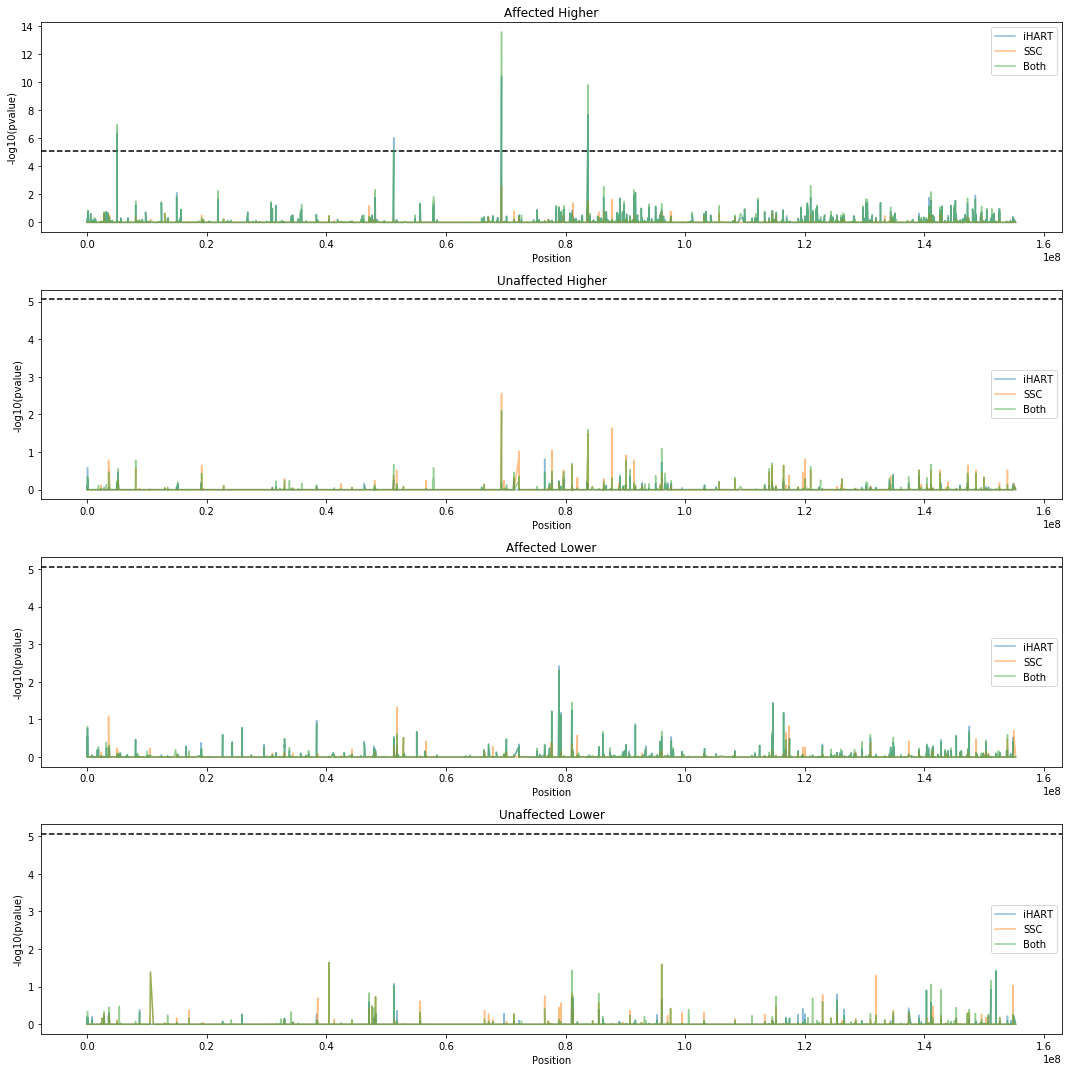

In [1617]:
plt.figure(figsize=(15, 15))
 
cutoff = -np.log10(0.05/len(contingency_both_aff))
#cutoff = -np.log10(0.05/len(all_collections))

plt.subplot(4, 1, 1)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Affected Higher')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions, -np.log10(pvalues_ihart_aff[:, -1, 0]), alpha=0.5, label='iHART')
plt.plot(positions, -np.log10(pvalues_ssc_aff[:, -1, 0]), alpha=0.5, label='SSC')
plt.plot(positions, -np.log10(pvalues_both_aff[:, -1, 0]), alpha=0.5, label='Both')
plt.legend()

plt.subplot(4, 1, 2)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Unaffected Higher')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions, -np.log10(pvalues_ihart_unaff[:, -1, 0]), alpha=0.5, label='iHART')
plt.plot(positions, -np.log10(pvalues_ssc_unaff[:, -1, 0]), alpha=0.5, label='SSC')
plt.plot(positions, -np.log10(pvalues_both_unaff[:, -1, 0]), alpha=0.5, label='Both')
plt.legend()

plt.subplot(4, 1, 3)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Affected Lower')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions, -np.log10(pvalues_ihart_aff[:, -1, 1]), alpha=0.5, label='iHART')
plt.plot(positions, -np.log10(pvalues_ssc_aff[:, -1, 1]), alpha=0.5, label='SSC')
plt.plot(positions, -np.log10(pvalues_both_aff[:, -1, 1]), alpha=0.5, label='Both')
plt.legend()

plt.subplot(4, 1, 4)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Unaffected Lower')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions, -np.log10(pvalues_ihart_unaff[:, -1, 1]), alpha=0.5, label='iHART')
plt.plot(positions, -np.log10(pvalues_ssc_unaff[:, -1, 1]), alpha=0.5, label='SSC')
plt.plot(positions, -np.log10(pvalues_both_unaff[:, -1, 1]), alpha=0.5, label='Both')
plt.legend()

plt.tight_layout()
plt.show()

In [1618]:
import bayesian_transmission_rate as btr
import importlib
importlib.reload(bayesian_transmission_rate)

#ihart
transrates_ihart_aff = btr.calculate_transmission_rates(contingency_ihart_aff, ihart_family_sizes)
transrates_ihart_unaff = btr.calculate_transmission_rates(contingency_ihart_unaff, ihart_family_sizes)

transrates_ihart_aff_m = btr.calculate_transmission_rates(contingency_ihart_aff_m, ihart_family_sizes)
transrates_ihart_unaff_m = btr.calculate_transmission_rates(contingency_ihart_unaff_m, ihart_family_sizes)

transrates_ihart_aff_f = btr.calculate_transmission_rates(contingency_ihart_aff_f, ihart_family_sizes)
transrates_ihart_unaff_f = btr.calculate_transmission_rates(contingency_ihart_unaff_f, ihart_family_sizes)

transrates_ihart_aff_f_pat = btr.calculate_transmission_rates(contingency_ihart_aff_f_pat, ihart_family_sizes)
transrates_ihart_unaff_f_pat = btr.calculate_transmission_rates(contingency_ihart_unaff_f_pat, ihart_family_sizes)

#ssc
transrates_ssc_aff = btr.calculate_transmission_rates(contingency_ssc_aff, ihart_family_sizes)
transrates_ssc_unaff = btr.calculate_transmission_rates(contingency_ssc_unaff, ihart_family_sizes)

transrates_ssc_aff_m = btr.calculate_transmission_rates(contingency_ssc_aff_m, ihart_family_sizes)
transrates_ssc_unaff_m = btr.calculate_transmission_rates(contingency_ssc_unaff_m, ihart_family_sizes)

transrates_ssc_aff_f = btr.calculate_transmission_rates(contingency_ssc_aff_f, ihart_family_sizes)
transrates_ssc_unaff_f = btr.calculate_transmission_rates(contingency_ssc_unaff_f, ihart_family_sizes)

transrates_ssc_aff_f_pat = btr.calculate_transmission_rates(contingency_ssc_aff_f_pat, ihart_family_sizes)
transrates_ssc_unaff_f_pat = btr.calculate_transmission_rates(contingency_ssc_unaff_f_pat, ihart_family_sizes)

#both
transrates_both_aff = btr.calculate_transmission_rates(contingency_both_aff, ihart_family_sizes)
transrates_both_unaff = btr.calculate_transmission_rates(contingency_both_unaff, ihart_family_sizes)

transrates_both_aff_m = btr.calculate_transmission_rates(contingency_both_aff_m, ihart_family_sizes)
transrates_both_unaff_m = btr.calculate_transmission_rates(contingency_both_unaff_m, ihart_family_sizes)

transrates_both_aff_f = btr.calculate_transmission_rates(contingency_both_aff_f, ihart_family_sizes)
transrates_both_unaff_f = btr.calculate_transmission_rates(contingency_both_unaff_f, ihart_family_sizes)

transrates_both_aff_f_pat = btr.calculate_transmission_rates(contingency_both_aff_f_pat, ihart_family_sizes)
transrates_both_unaff_f_pat = btr.calculate_transmission_rates(contingency_both_unaff_f_pat, ihart_family_sizes)


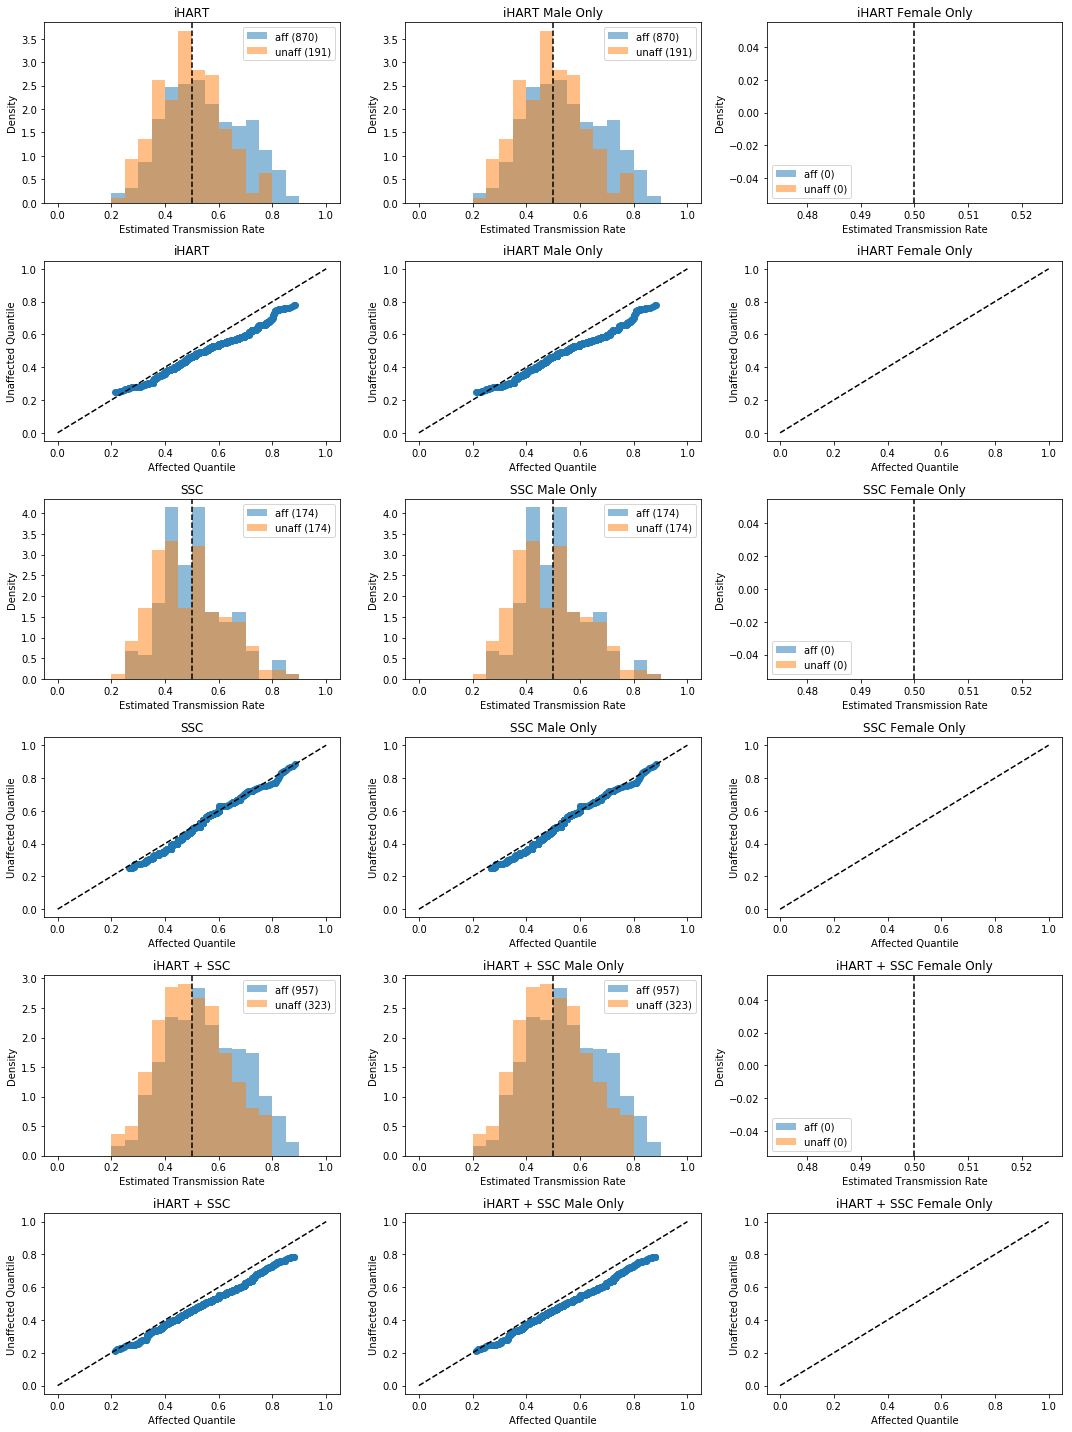

In [1619]:
plt.figure(figsize=(15, 20))

bin_size = 0.05
bins = np.arange(0, 1+bin_size, bin_size)

# --------- iHART ---------

#hist
plt.subplot(6, 3, 1)
plt.hist(transrates_ihart_aff[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_ihart_aff[ind_indices])), density=True)
plt.hist(transrates_ihart_unaff[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_ihart_unaff[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(6, 3, 2)
plt.hist(transrates_ihart_aff_m[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_ihart_aff_m[ind_indices])), density=True)
plt.hist(transrates_ihart_unaff_m[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_ihart_unaff_m[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART Male Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(6, 3, 3)
plt.hist(transrates_ihart_aff_f[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_ihart_aff_f[ind_indices])), density=True)
plt.hist(transrates_ihart_unaff_f[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_ihart_unaff_f[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART Female Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

# quantiles
plt.subplot(6, 3, 4)
plt.scatter(np.nanquantile(transrates_ihart_aff[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_ihart_unaff[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('iHART')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.subplot(6, 3, 5)
plt.scatter(np.nanquantile(transrates_ihart_aff_m[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_ihart_unaff_m[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('iHART Male Only')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.subplot(6, 3, 6)
plt.scatter(np.nanquantile(transrates_ihart_aff_f[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_ihart_unaff_f[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('iHART Female Only')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

# --------- SSC ---------

#hist
plt.subplot(6, 3, 7)
plt.hist(transrates_ssc_aff[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_ssc_aff[ind_indices])), density=True)
plt.hist(transrates_ssc_unaff[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_ssc_unaff[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('SSC')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(6, 3, 8)
plt.hist(transrates_ssc_aff_m[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_ssc_aff_m[ind_indices])), density=True)
plt.hist(transrates_ssc_unaff_m[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_ssc_unaff_m[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('SSC Male Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(6, 3, 9)
plt.hist(transrates_ssc_aff_f[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_ssc_aff_f[ind_indices])), density=True)
plt.hist(transrates_ssc_unaff_f[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_ssc_unaff_f[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('SSC Female Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

# quantiles
plt.subplot(6, 3, 10)
plt.scatter(np.nanquantile(transrates_ssc_aff[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_ssc_unaff[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SSC')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.subplot(6, 3, 11)
plt.scatter(np.nanquantile(transrates_ssc_aff_m[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_ssc_unaff_m[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SSC Male Only')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.subplot(6, 3, 12)
plt.scatter(np.nanquantile(transrates_ssc_aff_f[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_ssc_unaff_f[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('SSC Female Only')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

# --------- Both ---------

#hist
plt.subplot(6, 3, 13)
plt.hist(transrates_both_aff[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_both_aff[ind_indices])), density=True)
plt.hist(transrates_both_unaff[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_both_unaff[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART + SSC')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(6, 3, 14)
plt.hist(transrates_both_aff_m[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_both_aff_m[ind_indices])), density=True)
plt.hist(transrates_both_unaff_m[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_both_unaff_m[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART + SSC Male Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(6, 3, 15)
plt.hist(transrates_both_aff_f[ind_indices], bins=bins, 
         alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_both_aff_f[ind_indices])), density=True)
plt.hist(transrates_both_unaff_f[ind_indices], bins=bins, 
         alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_both_unaff_f[ind_indices])), density=True)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART + SSC Female Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

# quantiles
plt.subplot(6, 3, 16)
plt.scatter(np.nanquantile(transrates_both_aff[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_both_unaff[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('iHART + SSC')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.subplot(6, 3, 17)
plt.scatter(np.nanquantile(transrates_both_aff_m[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_both_unaff_m[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('iHART + SSC Male Only')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.subplot(6, 3, 18)
plt.scatter(np.nanquantile(transrates_both_aff_f[ind_indices], np.arange(0, 1, 0.001)), 
            np.nanquantile(transrates_both_unaff_f[ind_indices], np.arange(0, 1, 0.001)))
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('iHART + SSC Female Only')
plt.xlabel('Affected Quantile')
plt.ylabel('Unaffected Quantile')

plt.tight_layout()
plt.show()


min length 2 max length 562222 num 4213 median 665.0


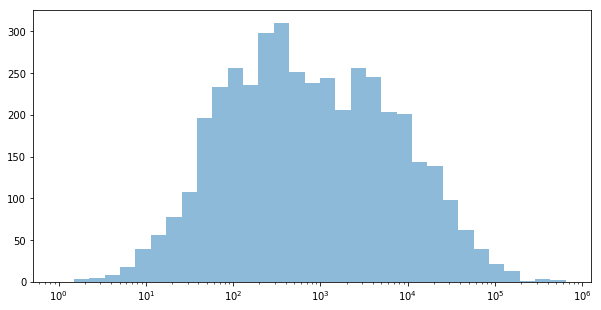

In [1620]:
import math

lengths = [all_collections[i].deletion.length for i in np.where(ind_indices)[0]]


plt.figure(figsize=(10, 5))
base = 1.5
max_length = max(lengths) 
min_length = min(lengths) 
print('min length', min(lengths) , 'max length', max(lengths) , 'num', len(lengths), 'median', np.median(lengths))

plt.hist(lengths, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)], alpha=0.5)

plt.gca().set_xscale("log")
plt.show()

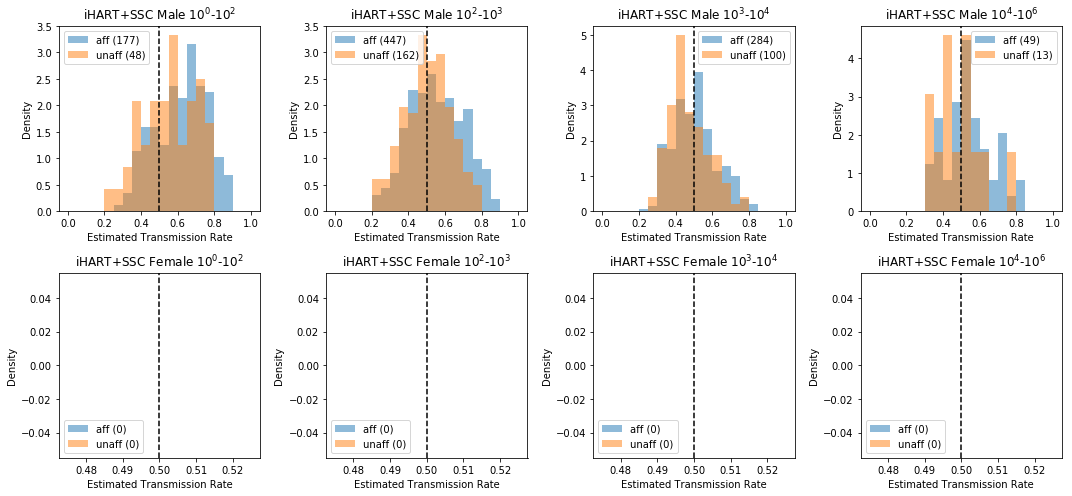

In [1621]:
plt.figure(figsize=(15, 7))

b = [0, 2, 3, 4, 6]
for i in range(len(b)-1):
    plt.subplot(2, 4, i+1)
    right_size = np.array([c.deletion.length > pow(10, b[i]) and c.deletion.length < pow(10, b[i+1]) for c in all_collections])
    plt.hist(transrates_both_aff_m[ind_indices & right_size], bins=bins, 
             alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_both_aff_m[ind_indices & right_size])), density=True)
    plt.hist(transrates_both_unaff_m[ind_indices & right_size], bins=bins, 
             alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_both_unaff_m[ind_indices & right_size])), density=True)
    plt.axvline(0.5, color='black', linestyle='--')
    plt.legend()
    plt.title('iHART+SSC Male $10^%d$-$10^%d$' % (b[i], b[i+1]))
    plt.xlabel('Estimated Transmission Rate')
    plt.ylabel('Density')
    
    plt.subplot(2, 4, i+5)
    right_size = np.array([c.deletion.length > pow(10, b[i]) and c.deletion.length < pow(10, b[i+1]) for c in all_collections])
    plt.hist(transrates_both_aff_f[ind_indices & right_size], bins=bins, 
             alpha=0.5, label='aff (%d)' % np.sum(~np.isnan(transrates_both_aff_f[ind_indices & right_size])), density=True)
    plt.hist(transrates_both_unaff_f[ind_indices & right_size], bins=bins, 
             alpha=0.5, label='unaff (%d)' % np.sum(~np.isnan(transrates_both_unaff_f[ind_indices & right_size])), density=True)
    plt.axvline(0.5, color='black', linestyle='--')
    plt.legend()
    plt.title('iHART+SSC Female $10^%d$-$10^%d$' % (b[i], b[i+1]))
    plt.xlabel('Estimated Transmission Rate')
    plt.ylabel('Density')
    
plt.tight_layout()
plt.show()

In [5]:
ps = np.arange(0, 1.001, 0.001)
prior = scipy.stats.beta.pdf(ps, 2, 2)
def calc_posterior(trans, notrans):
    Ls = np.ones((ps.shape[0], 5))    
    for i in range(1, 5):
        Ls[:, i] = np.power(qs[:, i], trans[i]) * np.power(1-qs[:, i], notrans[i])

    likelihood = np.product(Ls, axis=1)
    posterior = likelihood * prior
    return posterior*ps.shape[0]/np.sum(posterior)

def calculate_posteriors(contingency, family_sizes, verbose=True):
    # chrom, collection, family_size
    posteriors = np.ones((contingency.shape[0], ps.shape[0]))
    if verbose:
        print(chrom, end=' ')
    for j in range(contingency.shape[0]):
        posteriors[j, :] = calc_posterior(contingency[j, :, 1], contingency[j, :, 0])
    return posteriors

#ihart
posteriors_ihart_aff = calculate_posteriors(contingency_ihart_aff, ihart_family_sizes)
posteriors_ihart_unaff = calculate_posteriors(contingency_ihart_unaff, ihart_family_sizes)

posteriors_ihart_aff_m = calculate_posteriors(contingency_ihart_aff_m, ihart_family_sizes)
posteriors_ihart_unaff_m = calculate_posteriors(contingency_ihart_unaff_m, ihart_family_sizes)

posteriors_ihart_aff_f = calculate_posteriors(contingency_ihart_aff_f, ihart_family_sizes)
posteriors_ihart_unaff_f = calculate_posteriors(contingency_ihart_unaff_f, ihart_family_sizes)

#ssc
posteriors_ssc_aff = calculate_posteriors(contingency_ssc_aff, ihart_family_sizes)
posteriors_ssc_unaff = calculate_posteriors(contingency_ssc_unaff, ihart_family_sizes)

posteriors_ssc_aff_m = calculate_posteriors(contingency_ssc_aff_m, ihart_family_sizes)
posteriors_ssc_unaff_m = calculate_posteriors(contingency_ssc_unaff_m, ihart_family_sizes)

posteriors_ssc_aff_f = calculate_posteriors(contingency_ssc_aff_f, ihart_family_sizes)
posteriors_ssc_unaff_f = calculate_posteriors(contingency_ssc_unaff_f, ihart_family_sizes)

#both
posteriors_both_aff = calculate_posteriors(contingency_both_aff, ihart_family_sizes)
posteriors_both_unaff = calculate_posteriors(contingency_both_unaff, ihart_family_sizes)

posteriors_both_aff_m = calculate_posteriors(contingency_both_aff_m, ihart_family_sizes)
posteriors_both_unaff_m = calculate_posteriors(contingency_both_unaff_m, ihart_family_sizes)

posteriors_both_aff_f = calculate_posteriors(contingency_both_aff_f, ihart_family_sizes)
posteriors_both_unaff_f = calculate_posteriors(contingency_both_unaff_f, ihart_family_sizes)


NameError: name 'contingency_ihart_aff' is not defined

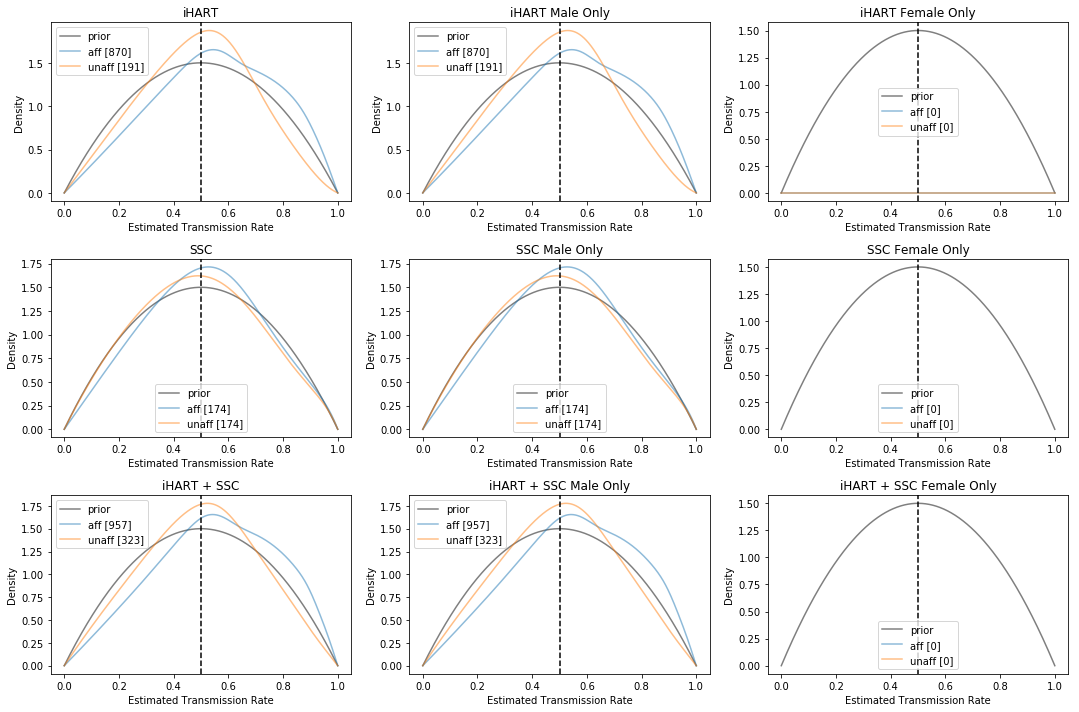

In [1623]:
plt.figure(figsize=(15, 10))

# --------- iHART ---------

#hist
plt.subplot(3, 3, 1)
these_indices = ind_indices & (np.sum(contingency_ihart_aff, axis=(1, 2))>=5)
n = np.sum(these_indices)
plt.plot(ps, prior, 
         alpha=0.5, label='prior', color='black')
plt.plot(ps, np.sum(posteriors_ihart_aff[these_indices, :]/n, axis=0), 
         alpha=0.5, label='aff [%d]' % n)
these_indices = ind_indices & (np.sum(contingency_ihart_unaff, axis=(1, 2))>=5)
n = np.sum(these_indices)
plt.plot(ps, np.sum(posteriors_ihart_unaff[these_indices, :]/n, axis=0), 
         alpha=0.5, label='unaff [%d]' % n)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(3, 3, 2)
these_indices = ind_indices & (np.sum(contingency_ihart_aff_m, axis=(1, 2))>=5)
n = np.sum(these_indices)
plt.plot(ps,prior, 
         alpha=0.5, label='prior', color='black')
plt.plot(ps, np.sum(posteriors_ihart_aff_m[these_indices, :]/n, axis=0), 
         alpha=0.5, label='aff [%d]' % n)
these_indices = ind_indices & (np.sum(contingency_ihart_unaff_m, axis=(1, 2))>=5)
n = np.sum(these_indices)
plt.plot(ps, np.sum(posteriors_ihart_unaff_m[these_indices, :]/n, axis=0), 
         alpha=0.5, label='unaff [%d]' % n)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART Male Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(3, 3, 3)
these_indices = ind_indices & (np.sum(contingency_ihart_aff_f, axis=(1, 2))>=5)
n = np.sum(these_indices)
plt.plot(ps,prior, 
         alpha=0.5, label='prior', color='black')
plt.plot(ps, np.sum(posteriors_ihart_aff_f[these_indices, :]/n, axis=0), 
         alpha=0.5, label='aff [%d]' % n)
these_indices = ind_indices & (np.sum(contingency_ihart_unaff_f, axis=(1, 2))>=5)
n = np.sum(these_indices)
plt.plot(ps, np.sum(posteriors_ihart_unaff_f[these_indices, :]/n, axis=0), 
         alpha=0.5, label='unaff [%d]' % n)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART Female Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

## quantiles
#plt.subplot(6, 3, 4)
#plt.scatter(np.cumsum(np.sum(posteriors_ihart_aff[ind_indices, :], axis=0)), 
#            np.cumsum(np.sum(posteriors_ihart_unaff[ind_indices, :], axis=0)))
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')
#plt.title('iHART')
#plt.xlabel('Affected Quantile')
#plt.ylabel('Unaffected Quantile')
#
#plt.subplot(6, 3, 5)
#plt.scatter(np.nanquantile(transrates_ihart_aff_m[ind_indices], np.arange(0, 1, 0.001)), 
#            np.nanquantile(transrates_ihart_unaff_m[ind_indices], np.arange(0, 1, 0.001)))
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')
#plt.title('iHART Male Only')
#plt.xlabel('Affected Quantile')
#plt.ylabel('Unaffected Quantile')
#
#plt.subplot(6, 3, 6)
#plt.scatter(np.nanquantile(transrates_ihart_aff_f[ind_indices], np.arange(0, 1, 0.001)), 
#            np.nanquantile(transrates_ihart_unaff_f[ind_indices], np.arange(0, 1, 0.001)))
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')
#plt.title('iHART Female Only')
#plt.xlabel('Affected Quantile')
#plt.ylabel('Unaffected Quantile')

# --------- SSC ---------

#hist
plt.subplot(3, 3, 4)
these_indices = ind_indices & (np.sum(contingency_ssc_aff, axis=(1, 2))>=5)
n = np.sum(these_indices)
plt.plot(ps,prior, 
         alpha=0.5, label='prior', color='black')
x = np.mean(posteriors_ssc_aff[these_indices, :], axis=0)
s = np.std(posteriors_ssc_aff[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='aff [%d]' % n)
#plt.fill_between(ps, np.clip(x-(2*s), -1, None), np.clip(x+(2*s), None, 2), alpha=0.1)

these_indices = ind_indices & (np.sum(contingency_ssc_unaff, axis=(1, 2))>=5)
n = np.sum(these_indices)
x = np.mean(posteriors_ssc_unaff[these_indices, :], axis=0)
s = np.std(posteriors_ssc_unaff[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='unaff [%d]' % n)
#plt.fill_between(ps, np.clip(x-(2*s), -1, None), np.clip(x+(2*s), None, 2), alpha=0.1)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('SSC')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(3, 3, 5)
these_indices = ind_indices & (np.sum(contingency_ssc_aff_m, axis=(1, 2))>=5)
n = np.sum(these_indices)
plt.plot(ps,prior, 
         alpha=0.5, label='prior', color='black')
x = np.mean(posteriors_ssc_aff_m[these_indices, :], axis=0)
s = np.std(posteriors_ssc_aff_m[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='aff [%d]' % n)
#plt.fill_between(ps, np.clip(x-(2*s), -1, None), np.clip(x+(2*s), None, 2), alpha=0.1)

these_indices = ind_indices & (np.sum(contingency_ssc_unaff_m, axis=(1, 2))>=5)
n = np.sum(these_indices)
x = np.mean(posteriors_ssc_unaff_m[these_indices, :], axis=0)
s = np.std(posteriors_ssc_unaff_m[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='unaff [%d]' % n)
#plt.fill_between(ps, np.clip(x-(2*s), -1, None), np.clip(x+(2*s), None, 2), alpha=0.1)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('SSC Male Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(3, 3, 6)
these_indices = ind_indices & (np.sum(contingency_ssc_aff_f, axis=(1, 2))>=5)
n = np.sum(these_indices)
plt.plot(ps,prior, 
         alpha=0.5, label='prior', color='black')
x = np.mean(posteriors_ssc_aff_f[these_indices, :], axis=0)
s = np.std(posteriors_ssc_aff_f[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='aff [%d]' % n)
#plt.fill_between(ps, np.clip(x-(2*s), -1, None), np.clip(x+(2*s), None, 2), alpha=0.1)

these_indices = ind_indices & (np.sum(contingency_ssc_unaff_f, axis=(1, 2))>=5)
n = np.sum(these_indices)
x = np.mean(posteriors_ssc_unaff_f[these_indices, :], axis=0)
s = np.std(posteriors_ssc_unaff_f[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='unaff [%d]' % n)
#plt.fill_between(ps, np.clip(x-(2*s), -1, None), np.clip(x+(2*s), None, 2), alpha=0.1)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('SSC Female Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

## quantiles
#plt.subplot(6, 3, 10)
#plt.scatter(np.nanquantile(transrates_ssc_aff[ind_indices], np.arange(0, 1, 0.001)), 
#            np.nanquantile(transrates_ssc_unaff[ind_indices], np.arange(0, 1, 0.001)))
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')
#plt.title('SSC')
#plt.xlabel('Affected Quantile')
#plt.ylabel('Unaffected Quantile')
#
#plt.subplot(6, 3, 11)
#plt.scatter(np.nanquantile(transrates_ssc_aff_m[ind_indices], np.arange(0, 1, 0.001)), 
#            np.nanquantile(transrates_ssc_unaff_m[ind_indices], np.arange(0, 1, 0.001)))
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')
#plt.title('SSC Male Only')
#plt.xlabel('Affected Quantile')
#plt.ylabel('Unaffected Quantile')
#
#plt.subplot(6, 3, 12)
#plt.scatter(np.nanquantile(transrates_ssc_aff_f[ind_indices], np.arange(0, 1, 0.001)), 
#            np.nanquantile(transrates_ssc_unaff_f[ind_indices], np.arange(0, 1, 0.001)))
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')
#plt.title('SSC Female Only')
#plt.xlabel('Affected Quantile')
#plt.ylabel('Unaffected Quantile')

# --------- Both ---------

#hist
plt.subplot(3, 3, 7)
these_indices = ind_indices & (np.sum(contingency_both_aff, axis=(1, 2))>=5)
n = np.sum(these_indices)
plt.plot(ps,prior,  alpha=0.5, label='prior', color='black')
x = np.mean(posteriors_both_aff[these_indices, :], axis=0)
s = np.std(posteriors_both_aff[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='aff [%d]' % n)
#plt.fill_between(ps, 
#                 np.quantile(posteriors_both_aff[these_indices, :], 0.025, axis=0), 
#                 np.clip(np.quantile(posteriors_both_aff[these_indices, :], 0.975, axis=0), None, 2), alpha=0.1)

these_indices = ind_indices & (np.sum(contingency_both_unaff, axis=(1, 2))>=5)
n = np.sum(these_indices)
x = np.mean(posteriors_both_unaff[these_indices, :], axis=0)
s = np.std(posteriors_both_unaff[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='unaff [%d]' % n)
#plt.fill_between(ps, 
#                 np.quantile(posteriors_both_unaff[these_indices, :], 0.025, axis=0), 
#                 np.clip(np.quantile(posteriors_both_unaff[these_indices, :], 0.975, axis=0), None, 2), alpha=0.1)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART + SSC')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(3, 3, 8)
these_indices = ind_indices & (np.sum(contingency_both_aff_m, axis=(1, 2))>=5)
n = np.sum(these_indices)
plt.plot(ps,prior, 
         alpha=0.5, label='prior', color='black')
x = np.mean(posteriors_both_aff_m[these_indices, :], axis=0)
s = np.std(posteriors_both_aff_m[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='aff [%d]' % n)
#plt.fill_between(ps, 
#                 np.quantile(posteriors_both_aff_m[these_indices, :], 0.025, axis=0), 
#                 np.clip(np.quantile(posteriors_both_aff_m[these_indices, :], 0.975, axis=0), None, 2), alpha=0.1)

these_indices = ind_indices & (np.sum(contingency_both_unaff_m, axis=(1, 2))>=5)
n = np.sum(these_indices)
x = np.mean(posteriors_both_unaff_m[these_indices, :], axis=0)
s = np.std(posteriors_both_unaff_m[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='unaff [%d]' % n)
#plt.fill_between(ps, 
#                 np.quantile(posteriors_both_unaff_m[these_indices, :], 0.025, axis=0), 
#                 np.clip(np.quantile(posteriors_both_unaff_m[these_indices, :], 0.975, axis=0), None, 2), alpha=0.1)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART + SSC Male Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

plt.subplot(3, 3, 9)
these_indices = ind_indices & (np.sum(contingency_both_aff_f, axis=(1, 2))>=5)
n = np.sum(these_indices)
plt.plot(ps,prior, 
         alpha=0.5, label='prior', color='black')
x = np.mean(posteriors_both_aff_f[these_indices, :], axis=0)
s = np.std(posteriors_both_aff_f[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='aff [%d]' % n)
#plt.fill_between(ps, 
#                 np.quantile(posteriors_both_aff_f[these_indices, :], 0.025, axis=0), 
#                 np.clip(np.quantile(posteriors_both_aff_f[these_indices, :], 0.975, axis=0), None, 2), alpha=0.1)

these_indices = ind_indices & (np.sum(contingency_both_unaff_f, axis=(1, 2))>=5)
n = np.sum(these_indices)
x = np.mean(posteriors_both_unaff_f[these_indices, :], axis=0)
s = np.std(posteriors_both_unaff_f[these_indices, :], axis=0)
plt.plot(ps, x, alpha=0.5, label='unaff [%d]' % n)
#plt.fill_between(ps, 
#                 np.quantile(posteriors_both_unaff_f[these_indices, :], 0.025, axis=0), 
#                 np.clip(np.quantile(posteriors_both_unaff_f[these_indices, :], 0.975, axis=0), None, 2), alpha=0.1)
plt.axvline(0.5, color='black', linestyle='--')
plt.legend()
plt.title('iHART + SSC Female Only')
plt.xlabel('Estimated Transmission Rate')
plt.ylabel('Density')

## quantiles
#plt.subplot(6, 3, 16)
#plt.scatter(np.nanquantile(transrates_both_aff[ind_indices], np.arange(0, 1, 0.001)), 
#            np.nanquantile(transrates_both_unaff[ind_indices], np.arange(0, 1, 0.001)))
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')
#plt.title('iHART + SSC')
#plt.xlabel('Affected Quantile')
#plt.ylabel('Unaffected Quantile')
#
#plt.subplot(6, 3, 17)
#plt.scatter(np.nanquantile(transrates_both_aff_m[ind_indices], np.arange(0, 1, 0.001)), 
#            np.nanquantile(transrates_both_unaff_m[ind_indices], np.arange(0, 1, 0.001)))
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')
#plt.title('iHART + SSC Male Only')
#plt.xlabel('Affected Quantile')
#plt.ylabel('Unaffected Quantile')
#
#plt.subplot(6, 3, 18)
#plt.scatter(np.nanquantile(transrates_both_aff_f[ind_indices], np.arange(0, 1, 0.001)), 
#            np.nanquantile(transrates_both_unaff_f[ind_indices], np.arange(0, 1, 0.001)))
#plt.plot([0, 1], [0, 1], color='black', linestyle='--')
#plt.title('iHART + SSC Female Only')
#plt.xlabel('Affected Quantile')
#plt.ylabel('Unaffected Quantile')

plt.tight_layout()
plt.show()


In [1624]:
def calculate_posterior_overlap(aff_posterior, unaff_posterior, verbose=True):
    # chrom, collection, family_size
    overlaps = np.ones((aff_posterior.shape[0],))
    if verbose:
        print(chrom, end=' ')
    for j in range(aff_posterior.shape[0]):
        overlaps[j] = np.sum(np.minimum(aff_posterior[j, :], unaff_posterior[j, :]))/np.sum(aff_posterior[j, :])
    return overlaps

In [1625]:
overlap_ihart = calculate_posterior_overlap(posteriors_ihart_aff, posteriors_ihart_unaff)
overlap_ihart_m = calculate_posterior_overlap(posteriors_ihart_aff_m, posteriors_ihart_unaff_m)
overlap_ihart_f = calculate_posterior_overlap(posteriors_ihart_aff_f, posteriors_ihart_unaff_f)
print(np.min(overlap_ihart), np.min(overlap_ihart_m), np.min(overlap_ihart_f))

overlap_ssc = calculate_posterior_overlap(posteriors_ssc_aff, posteriors_ssc_unaff)
overlap_ssc_m = calculate_posterior_overlap(posteriors_ssc_aff_m, posteriors_ssc_unaff_m)
overlap_ssc_f = calculate_posterior_overlap(posteriors_ssc_aff_f, posteriors_ssc_unaff_f)
print(np.min(overlap_ssc), np.min(overlap_ssc_m), np.min(overlap_ssc_f))

overlap_both = calculate_posterior_overlap(posteriors_both_aff, posteriors_both_unaff)
overlap_both_m = calculate_posterior_overlap(posteriors_both_aff_m, posteriors_both_unaff_m)
overlap_both_f = calculate_posterior_overlap(posteriors_both_aff_f, posteriors_both_unaff_f)
print(np.min(overlap_both), np.min(overlap_both_m), np.min(overlap_both_f))

X X X 0.03735216045885761 0.03735216045885761 1.0
X X X 0.12876402014220595 0.12876402014220595 1.0
X X X 0.07134565845741976 0.07134565845741976 1.0


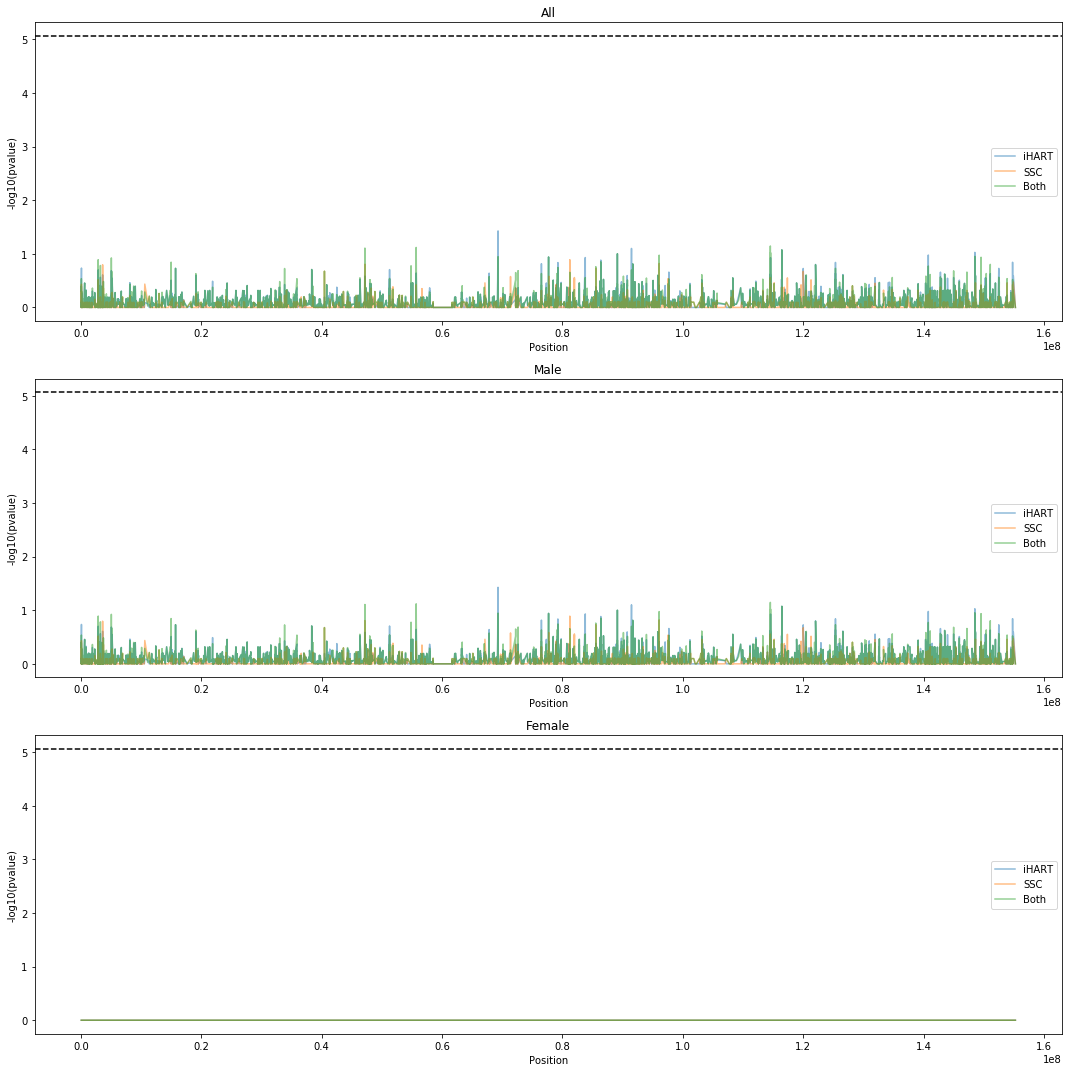

In [1626]:
plt.figure(figsize=(15, 15))
 
cutoff = -np.log10(0.05/len(contingency_both_aff))
#cutoff = -np.log10(0.05/len(all_collections))

plt.subplot(3, 1, 1)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('All')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions, -np.log10(overlap_ihart), alpha=0.5, label='iHART')
plt.plot(positions, -np.log10(overlap_ssc), alpha=0.5, label='SSC')
plt.plot(positions, -np.log10(overlap_both), alpha=0.5, label='Both')
plt.legend()

plt.subplot(3, 1, 2)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Male')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions, -np.log10(overlap_ihart_m), alpha=0.5, label='iHART')
plt.plot(positions, -np.log10(overlap_ssc_m), alpha=0.5, label='SSC')
plt.plot(positions, -np.log10(overlap_both_m), alpha=0.5, label='Both')
plt.legend()

plt.subplot(3, 1, 3)
plt.axhline(cutoff, linestyle='--', color='black')
plt.ylabel('-log10(pvalue)')
plt.xlabel('Position')
plt.title('Female')
positions = np.array([c.deletion.start_pos for c in all_collections])
plt.plot(positions, -np.log10(overlap_ihart_f), alpha=0.5, label='iHART')
plt.plot(positions, -np.log10(overlap_ssc_f), alpha=0.5, label='SSC')
plt.plot(positions, -np.log10(overlap_both_f), alpha=0.5, label='Both')
plt.legend()

plt.tight_layout()
plt.show()

Max 0.515
Mean 0.5140278053286313
Credible Interval [0.48, 0.55]


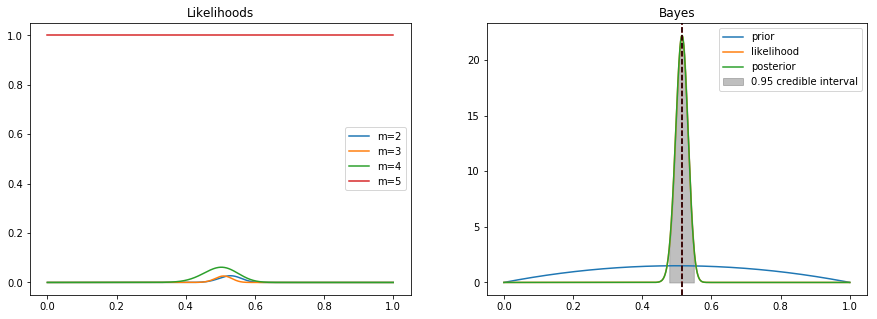

In [7]:
plt.figure(figsize=(15, 5))

ps = np.arange(0, 1.001, 0.001)
prior = scipy.stats.beta.pdf(ps, 2, 2)

qs = np.zeros((ps.shape[0], 5))
qs[0, :] = [1/(x+1) for x in range(5)]
for i in range(5):
    qs[1:, i] = ps[1:]/(1-(1-ps[1:])**(i+1))
    
xs = [11, 676, 553, 90, 0]
ys = [0, 318, 404, 78, 0]


plt.subplot(1, 2, 1)
plt.title('Likelihoods')
Ls = np.ones((ps.shape[0], 5))    
for i in range(1, 5):
    Ls[:, i] = scipy.special.comb(xs[i]+ys[i], xs[i]) * np.power(qs[:, i], xs[i]) * np.power(1-qs[:, i], ys[i])

for i in range(1, 5):
    plt.plot(ps, Ls[:, i], label='m=%d' % (i+1))
likelihood = np.product(Ls, axis=1)
likelihood = likelihood*ps.shape[0]/np.sum(likelihood)
plt.legend()

plt.subplot(1, 2, 2)
prior = scipy.stats.beta.pdf(ps, 2, 2)
prior = prior*ps.shape[0]/np.sum(prior)
posterior = likelihood * prior
posterior = posterior*ps.shape[0]/np.sum(posterior)
plt.plot(ps, prior, label='prior')
plt.plot(ps, likelihood, label='likelihood')
plt.plot(ps, posterior, label='posterior')
plt.title('Bayes')

posterior_max = ps[np.argmax(posterior)]
posterior_mean = np.mean(ps*posterior)
cred_l_index = np.argmin(np.abs(np.cumsum(posterior) - 0.025*ps.shape[0]))
cred_u_index = ps.shape[0]-np.argmin(np.abs(np.cumsum(np.flip(posterior)) - 0.025*ps.shape[0]))
posterior_cred_l = ps[cred_l_index]
posterior_cred_u = ps[cred_u_index]

print('Max', posterior_max)
print('Mean', posterior_mean)
print('Credible Interval [%.02f, %0.2f]' % (posterior_cred_l, posterior_cred_u))
plt.axvline(posterior_max, color='red', linestyle='--')
plt.axvline(posterior_mean, color='black', linestyle='--')
plt.fill_between(ps[cred_l_index:cred_u_index], posterior[cred_l_index:cred_u_index], color='gray', alpha=0.5, label='0.95 credible interval')

plt.legend()
plt.show()

In [1138]:
print(np.sum(contingency_both_aff, axis=1).shape)

(617, 2)


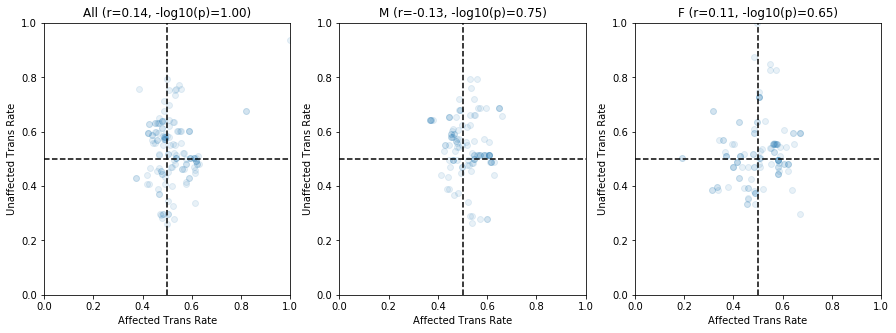

In [1139]:
from scipy.stats.stats import pearsonr

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(transrates_ihart_aff, transrates_ihart_unaff, alpha=0.1)
plt.xlabel('Affected Trans Rate')
plt.ylabel('Unaffected Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

indices = ~np.isnan(transrates_ihart_aff) & ~np.isnan(transrates_ihart_unaff)
r, p = pearsonr(transrates_ihart_aff[indices], transrates_ihart_unaff[indices])
plt.title('All (r=%0.2f, -log10(p)=%0.2f)' % (r, -np.log10(p)))

plt.subplot(1, 3, 2)
plt.scatter(transrates_ihart_aff_m, transrates_ihart_unaff_m, alpha=0.1)
plt.xlabel('Affected Trans Rate')
plt.ylabel('Unaffected Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

indices = ~np.isnan(transrates_ihart_aff_m) & ~np.isnan(transrates_ihart_unaff_m)
r, p = pearsonr(transrates_ihart_aff_m[indices], transrates_ihart_unaff_m[indices])
plt.title('M (r=%0.2f, -log10(p)=%0.2f)' % (r, -np.log10(p)))

plt.subplot(1, 3, 3)
plt.scatter(transrates_ihart_aff_f, transrates_ihart_unaff_f, alpha=0.1)
plt.xlabel('Affected Trans Rate')
plt.ylabel('Unaffected Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

indices = ~np.isnan(transrates_ihart_aff_f) & ~np.isnan(transrates_ihart_unaff_f)
r, p = pearsonr(transrates_ihart_aff_f[indices], transrates_ihart_unaff_f[indices])
plt.title('F (r=%0.2f, -log10(p)=%0.2f)' % (r, -np.log10(p)))

plt.show()

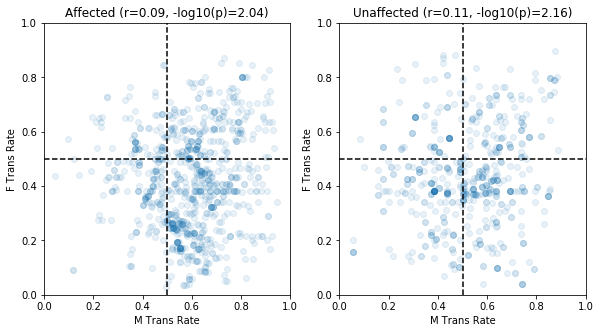

In [920]:
from scipy.stats.stats import pearsonr

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(transrates_ihart_aff_m, transrates_ihart_aff_f, alpha=0.1)
plt.xlabel('M Trans Rate')
plt.ylabel('F Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

indices = ~np.isnan(transrates_ihart_aff_m) & ~np.isnan(transrates_ihart_aff_f)
r, p = pearsonr(transrates_ihart_aff_m[indices], transrates_ihart_aff_f[indices])
plt.title('Affected (r=%0.2f, -log10(p)=%0.2f)' % (r, -np.log10(p)))

plt.subplot(1, 3, 2)
plt.scatter(transrates_ihart_unaff_m, transrates_ihart_unaff_f, alpha=0.1)
plt.xlabel('M Trans Rate')
plt.ylabel('F Trans Rate')
plt.axhline(0.5, color='black', linestyle='--')
plt.axvline(0.5, color='black', linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])

indices = ~np.isnan(transrates_ihart_unaff_m) & ~np.isnan(transrates_ihart_unaff_f)
r, p = pearsonr(transrates_ihart_unaff_m[indices], transrates_ihart_unaff_f[indices])
plt.title('Unaffected (r=%0.2f, -log10(p)=%0.2f)' % (r, -np.log10(p)))

plt.show()

In [508]:
def printout(j):
    print('%s:%d-%d %0.2f/%0.2f/%0.2f/%0.2f (%0.2f [%d]/%0.2f [%d])' % (
            chrom, all_collections[j].deletion.start_pos, all_collections[j].deletion.end_pos, 
            -np.log10(pvalues_ihart_aff[j, -1, 0]), -np.log10(pvalues_ihart_aff[j, -1, 1]), -np.log10(pvalues_ihart_unaff[j, -1, 0]), -np.log10(pvalues_ihart_unaff[j, -1, 1]),
            transrates_ihart_aff[j], np.sum(contingency_ihart_aff[j, :, :]), 
            transrates_ihart_unaff[j], np.sum(contingency_ihart_unaff[j, :, :])))

print('Affected Higher')
for j in np.where((-np.log10(pvalues_ihart_aff[:, -1, 0]) >= cutoff))[0]:
    printout(j)

print('Unaffected Higher')
for j in np.where((-np.log10(pvalues_ihart_unaff[:, -1, 0]) >= cutoff))[0]:
    printout(j)

print('Affected Lower')
for j in np.where((-np.log10(pvalues_ihart_aff[:, -1, 1]) >= cutoff))[0]:
    printout(j)
        
print('Unaffected Lower')
for j in np.where((-np.log10(pvalues_ihart_unaff[:, -1, 1]) >= cutoff))[0]:
    printout(j)
   

Affected Higher
X:51275282-51275296 6.87/0.00/1.32/0.00 (nan [63]/0.89 [18])
X:69303199-69303266 11.31/0.00/0.09/0.00 (nan [132]/nan [38])
X:83796825-83796931 7.64/0.00/0.04/0.06 (nan [87]/nan [23])
Unaffected Higher
Affected Lower
Unaffected Lower


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater_equal
  del sys.path[0]
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater_equal
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater_equal


In [509]:
tr_aff = transrates_ihart_aff
tr_unaff = transrates_ihart_unaff
n_aff = np.sum(contingency_ihart_aff, axis=(1, 2))
n_unaff = np.sum(contingency_ihart_unaff, axis=(1, 2))
c_aff = 2*np.sqrt(tr_aff*(1-tr_aff)/(n_aff))
c_unaff = 2*np.sqrt(tr_unaff*(1-tr_unaff)/(n_unaff))

tr_aff_l = tr_aff - c_aff
tr_aff_u = tr_aff + c_aff
tr_unaff_l = tr_unaff - c_unaff
tr_unaff_u = tr_unaff + c_unaff

indices_of_interest = ((tr_aff_u < tr_unaff_l) | (tr_unaff_u < tr_aff_l))
collections_of_interest = [all_collections[j] for j in np.where(indices_of_interest)[0]]
    
print(len(collections_of_interest))
for j in np.where(indices_of_interest)[0]:
    c = all_collections[j]
    print('%s:%d-%d [%0.2f, %0.2f, %0.2f]/[%0.2f, %0.2f, %0.2f]' % (c.deletion.chrom, c.deletion.start_pos, c.deletion.end_pos,
                                                                   tr_aff_l[j], tr_aff[j], tr_aff_u[j],
                                                                   tr_unaff_l[j], tr_unaff[j], tr_unaff_u[j],))
    

58
X:3606240-3606641 [0.44, 0.52, 0.60]/[0.13, 0.29, 0.44]
X:3606245-3606641 [0.44, 0.52, 0.59]/[0.13, 0.29, 0.44]
X:42512382-42513868 [0.50, 0.56, 0.63]/[0.21, 0.34, 0.47]
X:42512393-42513868 [0.49, 0.56, 0.62]/[0.18, 0.30, 0.43]
X:42512421-42513868 [0.48, 0.55, 0.62]/[0.19, 0.32, 0.45]
X:42512485-42513868 [0.45, 0.53, 0.60]/[0.17, 0.30, 0.44]
X:42512519-42513868 [0.46, 0.53, 0.60]/[0.17, 0.30, 0.44]
X:46356717-46356888 [0.00, 0.13, 0.26]/[0.30, 0.58, 0.85]
X:51279710-51279965 [0.33, 0.41, 0.48]/[-0.00, 0.09, 0.18]
X:51279712-51279965 [0.33, 0.41, 0.49]/[0.04, 0.16, 0.28]
X:67825307-67825674 [0.54, 0.65, 0.75]/[0.01, 0.23, 0.44]
X:67825344-67825674 [0.54, 0.65, 0.75]/[0.01, 0.23, 0.44]
X:67825379-67825674 [0.53, 0.64, 0.75]/[0.01, 0.23, 0.44]
X:67825379-67825676 [0.53, 0.64, 0.75]/[0.01, 0.23, 0.44]
X:67825379-67825688 [0.53, 0.64, 0.75]/[0.01, 0.23, 0.44]
X:67825379-67825720 [0.54, 0.65, 0.75]/[0.01, 0.23, 0.44]
X:67825382-67825704 [0.54, 0.65, 0.75]/[0.01, 0.23, 0.44]
X:67825387-678

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


In [510]:
tr_aff = transrates_ihart_aff_m
tr_unaff = transrates_ihart_unaff_m
n_aff = np.sum(contingency_ihart_aff_m, axis=(1, 2))
n_unaff = np.sum(contingency_ihart_unaff_m, axis=(1, 2))
c_aff = 2*np.sqrt(tr_aff*(1-tr_aff)/(n_aff))
c_unaff = 2*np.sqrt(tr_unaff*(1-tr_unaff)/(n_unaff))

tr_aff_l = tr_aff - c_aff
tr_aff_u = tr_aff + c_aff
tr_unaff_l = tr_unaff - c_unaff
tr_unaff_u = tr_unaff + c_unaff

indices_of_interest = ((tr_aff_u < tr_unaff_l) | (tr_unaff_u < tr_aff_l))
collections_of_interest = [all_collections[j] for j in np.where(indices_of_interest)[0]]
    
print(len(collections_of_interest))
for j in np.where(indices_of_interest)[0]:
    c = all_collections[j]
    print('%s:%d-%d [%0.2f, %0.2f, %0.2f]/[%0.2f, %0.2f, %0.2f]' % (c.deletion.chrom, c.deletion.start_pos, c.deletion.end_pos,
                                                                   tr_aff_l[j], tr_aff[j], tr_aff_u[j],
                                                                   tr_unaff_l[j], tr_unaff[j], tr_unaff_u[j],))


37
X:8786096-8788849 [0.47, 0.57, 0.68]/[-0.07, 0.07, 0.20]
X:32987100-32989059 [0.54, 0.68, 0.83]/[-0.16, 0.18, 0.52]
X:32987132-32989059 [0.54, 0.68, 0.83]/[-0.16, 0.18, 0.52]
X:55702300-55710399 [0.56, 0.61, 0.65]/[0.30, 0.42, 0.55]
X:67825307-67825674 [0.58, 0.69, 0.80]/[0.02, 0.27, 0.53]
X:67825344-67825674 [0.58, 0.69, 0.80]/[0.02, 0.27, 0.53]
X:67825379-67825674 [0.57, 0.68, 0.79]/[0.02, 0.27, 0.53]
X:67825379-67825676 [0.57, 0.68, 0.79]/[0.02, 0.27, 0.53]
X:67825379-67825688 [0.57, 0.68, 0.79]/[0.02, 0.27, 0.53]
X:67825379-67825720 [0.58, 0.69, 0.80]/[0.02, 0.27, 0.53]
X:67825382-67825704 [0.58, 0.69, 0.80]/[0.02, 0.27, 0.53]
X:67825387-67825676 [0.57, 0.68, 0.79]/[0.02, 0.27, 0.53]
X:67825387-67825704 [0.57, 0.68, 0.79]/[0.02, 0.27, 0.53]
X:67825395-67825704 [0.57, 0.68, 0.79]/[0.02, 0.27, 0.53]
X:95334338-95334716 [0.52, 0.69, 0.85]/[-0.16, 0.18, 0.52]
X:103146953-103155148 [0.56, 0.67, 0.77]/[0.04, 0.27, 0.50]
X:103147591-103155212 [0.56, 0.67, 0.77]/[0.04, 0.27, 0.50]
X:103

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


In [511]:
tr_aff = transrates_ihart_aff_f
tr_unaff = transrates_ihart_unaff_f
n_aff = np.sum(contingency_ihart_aff_f, axis=(1, 2))
n_unaff = np.sum(contingency_ihart_unaff_f, axis=(1, 2))
c_aff = 2*np.sqrt(tr_aff*(1-tr_aff)/(n_aff))
c_unaff = 2*np.sqrt(tr_unaff*(1-tr_unaff)/(n_unaff))

tr_aff_l = tr_aff - c_aff
tr_aff_u = tr_aff + c_aff
tr_unaff_l = tr_unaff - c_unaff
tr_unaff_u = tr_unaff + c_unaff

indices_of_interest = ((tr_aff_u < tr_unaff_l) | (tr_unaff_u < tr_aff_l))
collections_of_interest = [all_collections[j] for j in np.where(indices_of_interest)[0]]
    
print(len(collections_of_interest))
for j in np.where(indices_of_interest)[0]:
    c = all_collections[j]
    print('%s:%d-%d [%0.2f, %0.2f, %0.2f]/[%0.2f, %0.2f, %0.2f]' % (c.deletion.chrom, c.deletion.start_pos, c.deletion.end_pos,
                                                                   tr_aff_l[j], tr_aff[j], tr_aff_u[j],
                                                                   tr_unaff_l[j], tr_unaff[j], tr_unaff_u[j],))


23
X:5159108-5164784 [0.37, 0.61, 0.84]/[-0.04, 0.04, 0.12]
X:5159108-5164885 [0.37, 0.61, 0.84]/[-0.04, 0.04, 0.12]
X:5159482-5164204 [0.37, 0.61, 0.84]/[-0.04, 0.04, 0.12]
X:5159482-5164063 [0.37, 0.61, 0.84]/[-0.04, 0.04, 0.12]
X:38386487-38387219 [0.06, 0.18, 0.29]/[0.37, 0.59, 0.80]
X:42512007-42513868 [0.00, 0.08, 0.16]/[0.23, 0.41, 0.60]
X:42512012-42513868 [0.00, 0.08, 0.16]/[0.23, 0.41, 0.60]
X:42512051-42513868 [0.00, 0.08, 0.16]/[0.23, 0.41, 0.60]
X:42512071-42513868 [0.01, 0.10, 0.19]/[0.23, 0.41, 0.60]
X:42512163-42513868 [0.01, 0.10, 0.19]/[0.23, 0.41, 0.60]
X:42512197-42513868 [0.03, 0.12, 0.21]/[0.23, 0.41, 0.60]
X:71375083-71375431 [0.27, 0.55, 0.82]/[-0.05, 0.10, 0.25]
X:71375083-71375478 [0.27, 0.55, 0.82]/[-0.05, 0.10, 0.25]
X:71375083-71375503 [0.27, 0.55, 0.82]/[-0.05, 0.10, 0.25]
X:76509717-76510003 [-0.09, 0.10, 0.28]/[0.52, 0.83, 1.14]
X:81042512-81042929 [0.03, 0.12, 0.22]/[0.24, 0.41, 0.57]
X:81042512-81042877 [0.03, 0.12, 0.22]/[0.24, 0.41, 0.57]
X:97683802-

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]
